<div class="alert alert-block alert-success">
<b>Comentario general del revisor</b> <a class="tocSkip"></a><br />
Status del proyecto: <b>Aprobado</b>
</div>


¡Hola!<br />
Soy **Francisco Cortés**, estoy contento de revisar tu proyecto y ser parte de tu proceso de aprendizaje.
A lo largo del texto, haré algunas observaciones sobre mejoras en el código y también haré comentarios sobre tus percepciones sobre el tema. Si existe algún error en el código, no te preocupes, estoy aquí para ayudarte a mejorarlo, en la primera iteración te lo señalaré para que tengas la oportunidad de corregirlo, pero si aún no encuentras una solución para esta tarea, te daré una pista más precisa en la próxima iteración y también algunos ejemplos prácticos. Estaré abierto a retroalimentación y discusiones sobre el tema.<br />
Encontrarás mis comentarios a continuación - **por favor no los muevas, modifiques o borres**.
Revisaré cuidadosamente tu código para comprobar que se han cumplido con los requisitos y te proporcionaré mis comentarios en cajas verdes, amarillas o rojas como esta:

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Si la ejecución fue perfecta succesfully.
</div>

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Si existe alguna recomendación para que tu código mejore.
</div>

<div class="alert alert-block alert-danger">

<b>Comentario del revisor</b> <a class="tocSkip"></a>

Si existen correcciones necesarias para cumplir con los requisitos. El trabajo no puede ser aceptado si hay alguna caja roja.
</div>

Puedes responderme de la siguiente manera:

<div class="alert alert-block alert-info">
<b>Respuesta del estudiante.</b> <a class="tocSkip"></a>
</div>


# 1. Access datasets & prepare for analysis

In [1]:
import pandas as pd
import numpy as np

visits = pd.read_csv("/datasets/visits_log_us.csv")
orders = pd.read_csv("/datasets/orders_log_us.csv")
costs = pd.read_csv("/datasets/costs_us.csv")

visits.info()
orders.info()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 

In [2]:
# Rename and convert date columns in every dataframe to datetime format

visits.rename(columns={"Device":"device", "End Ts": "end_ts", "Source Id": "source_id", "Start Ts": "start_ts", "Uid":"uid"}, inplace=True)
orders.rename(columns={"Buy Ts": "buy_ts", "Revenue": "revenue", "Uid":"uid"}, inplace=True)

visits["end_ts"] = pd.to_datetime(visits["end_ts"])
visits["start_ts"] = pd.to_datetime(visits["start_ts"])
orders["buy_ts"] = pd.to_datetime(orders["buy_ts"])
costs["dt"] = pd.to_datetime(costs["dt"])

# Search for duplicated values
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br />
Bien hecho!<br/>

Los datos fueron revisados y modificados apropiadamente, ahora se puede empezar a trabajar con ellos comodomente
</div>


# 2. Metrics 

## 1. Visits
1. How many people use Showz every day, week and month?
2. How many sessions are there per day? (Single user might have more than 1 session)
3. How long is every session?
4. How often do users come back?

In [3]:
# 1. How many people use Showz every day, week and month?

visits["date"] = visits["start_ts"].dt.date
visits["week"] = visits["start_ts"].dt.to_period("W").dt.to_timestamp()
visits["month"] = visits["start_ts"].dt.to_period("M").dt.to_timestamp()

daily_users = visits.groupby("date")["uid"].nunique()
weekly_users = visits.groupby("week")["uid"].nunique()
monthly_users = visits.groupby("month")["uid"].nunique()

print("Daily average unique users:", daily_users.mean().round())
print("Weekly average unique users:", weekly_users.mean().round())
print("Monthly average unique users:", monthly_users.mean().round())

Daily average unique users: 908.0
Weekly average unique users: 5716.0
Monthly average unique users: 23228.0


In [4]:
# 2. How many sessions are there per day? (Single user might have more than 1 session)

daily_sessions = visits.groupby("date")["uid"].count().mean().round()
print(daily_sessions)

987.0


In [5]:
# 3. How long is every session?

visits["duration_min"] = (
    visits["end_ts"] - visits["start_ts"]
).dt.total_seconds() / 60
avg = visits["duration_min"].mean().round()
print(f"Average session time in mins: {avg}")


Average session time in mins: 11.0


In [6]:
# 4. How often do users come back?

# Sort by user and session date
visits_sorted = visits.sort_values(by=["uid", "start_ts"])


# Estimate last visit date for every user (for users with at least 2 sessions)
visits_sorted["previous_visit"] = visits_sorted.groupby("uid")["start_ts"].shift()

# Estimate days since last visit
visits_sorted["days_since_last_visit"] = (visits_sorted["start_ts"] - visits_sorted["previous_visit"]).dt.days


# Filter users who visited a second time
returning_visits = visits_sorted.dropna(subset=["days_since_last_visit"])

# C
avg_days_return = returning_visits["days_since_last_visit"].mean()
min_days_return = returning_visits["days_since_last_visit"].min()
max_days_return = returning_visits["days_since_last_visit"].max()

print(f"Average days between visits: {avg_days_return:.2f}")
print(f"Min days between visits: {min_days_return}")
print(f"Max days between visits: {max_days_return}")

Average days between visits: 27.68
Min days between visits: 0.0
Max days between visits: 362.0


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br />

Buena manera de crear nuevas columnas y de establecer el tipo de dato, esto es muy útil para el correcto manejo de los datos
</div>


## Sales

1. When do users start buying?
(In KPI analysis, we’re usually interested in the time between registration and conversion — that is, when a user becomes a customer. For example, if registration and the first purchase occur on the same day, the user would fall into the "Conversion 0d" category. If the first purchase happens the next day, it would be "Conversion 1d." You can use any approach that allows you to compare conversion timing across different cohorts to determine which cohort or marketing channel is most effective.)

2. How many orders do they place over a given period of time?

3. What is the average purchase size?

4. How much money do they bring? (LTV)

In [7]:
# 1. When do users start buying?

# Get first visit and first purchase for every user 

first_visit = visits.groupby('uid')['start_ts'].min().reset_index()
first_visit.rename(columns={"start_ts":"first_visit"}, inplace=True)

first_order = orders.groupby('uid')['buy_ts'].min().reset_index()
first_order.rename(columns={"buy_ts":"first_purchase"}, inplace=True)

# Merge tables

cohorts = pd.merge(first_order, first_visit, on='uid',how='inner') # inner deletes all users that never buy
# the first user that bought had its first visit the week of 30-05-2017

# Build weekly cohorts based on first visit date 

cohorts['cohort_month'] = (cohorts['first_visit'].dt.to_period('M').dt.to_timestamp().dt.date)

# Estimate days until first purchase
cohorts['days_to_convert'] = (cohorts['first_purchase'] - cohorts['first_visit']).dt.days

# Group by weekly cohorts
cohort_summary = (
    cohorts
    .groupby('cohort_month')['days_to_convert']
    .agg(
        users=('count'),
        avg_days_to_convert=('mean'),
    )
    .round()
    .reset_index()            
)

print("Days to conversion by cohort")
print(cohort_summary)


Days to conversion by cohort
   cohort_month  users  avg_days_to_convert
0    2017-06-01   2923                 46.0
1    2017-07-01   2458                 40.0
2    2017-08-01   1721                 33.0
3    2017-09-01   3058                 25.0
4    2017-10-01   4678                 17.0
5    2017-11-01   4262                 15.0
6    2017-12-01   4074                 11.0
7    2018-01-01   3119                  8.0
8    2018-02-01   3186                  5.0
9    2018-03-01   2838                  3.0
10   2018-04-01   1890                  2.0
11   2018-05-01   2316                  1.0


In [8]:
# 2. How many orders do they place over a given period of time?


# Crear column with order month 
orders['order_month'] = orders['buy_ts'].dt.to_period('M').dt.to_timestamp()

# Count orders by month
monthly_orders = orders.groupby('order_month').size().reset_index(name='n_orders')
monthly_average_orders = monthly_orders['n_orders'].mean()
print(f"Average monthly orders: {monthly_average_orders:.2f}")


Average monthly orders: 3878.08


In [9]:
# 3. What is the average purchase size?

avg_order_value = orders['revenue'].sum() / orders.shape[0]
print(f"Average purchase size: {avg_order_value:.2f}")


Average purchase size: 5.00


In [10]:
#4. How much money do they bring? (LTV)

# LTV by cohort

# Convert to datetime

cohorts['cohort_month'] = pd.to_datetime(cohorts['cohort_month'])

# Merge orders with cohorts
orders_with_cohort = pd.merge(
    orders,
    cohorts[['uid', 'cohort_month']],
    on='uid',
    how='inner'
)


# Estimate total revenue and buyers by cohort
ltv_by_cohort = (
    orders_with_cohort
    .groupby('cohort_month')
    .agg(
        total_revenue=('revenue', 'sum'),
        buyers=('uid', 'nunique')
    )
    .reset_index()
)

# LTV by cohort
ltv_by_cohort['LTV'] = ltv_by_cohort['total_revenue'] / ltv_by_cohort['buyers']
print(ltv_by_cohort)

   cohort_month  total_revenue  buyers        LTV
0    2017-06-01       40026.05    2923  13.693483
1    2017-07-01       17812.11    2458   7.246587
2    2017-08-01       13461.87    1721   7.822121
3    2017-09-01       33682.56    3058  11.014572
4    2017-10-01       27857.69    4678   5.955043
5    2017-11-01       24426.72    4262   5.731281
6    2017-12-01       31157.85    4074   7.647975
7    2018-01-01       14546.82    3119   4.663937
8    2018-02-01       15061.29    3186   4.727335
9    2018-03-01       13770.16    2838   4.852065
10   2018-04-01        9882.55    1890   5.228862
11   2018-05-01       10371.53    2316   4.478208


## Marketing:
1. How much money was spent?
(Total / by acquisition source / over time)
2. What was the customer acquisition cost (CAC) for each source?
3. How profitable were the investments? (ROMI)

In [11]:
# 1. How much money was spent? (Total / by acquisition source / over time

# Total cost

total_cost = costs["costs"].sum().round()
print("Marketing total cost:", total_cost)



# Total cost by source

cost_by_source = costs.groupby("source_id")["costs"].sum().sort_values(ascending=False)
print(f"\nMarketing cost by source:")
print(cost_by_source)

# Monthly cost over time

costs["month"] = costs["dt"].dt.to_period("M")

cost_over_time = costs.groupby("month")["costs"].sum().round(2).reset_index()
print("\nMarketing expend over time:")
print(cost_over_time.sort_values(by="costs", ascending=False))

Marketing total cost: 329132.0

Marketing cost by source:
source_id
3     141321.63
4      61073.60
5      51757.10
2      42806.04
1      20833.27
10      5822.49
9       5517.49
Name: costs, dtype: float64

Marketing expend over time:
      month     costs
6   2017-12  38315.35
5   2017-11  37907.88
4   2017-10  36322.88
7   2018-01  33518.52
8   2018-02  32723.03
9   2018-03  30415.27
3   2017-09  24368.91
10  2018-04  22289.38
11  2018-05  22224.27
1   2017-07  18240.59
0   2017-06  18015.00
2   2017-08  14790.54


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br />

Bien hecho!

Los gastos de marketing coinciden con los meses donde se ha conseguido una mejor adquisición de clientes
</div>


<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br />

En esta parte recomendaría agregar graficas que acompañen a las tablas
</div>


In [12]:
# 2. How profitable were the investments? (ROMI)

# Merge tables to identify acquisition source by user

orders_with_source = pd.merge(orders,visits[["source_id", "uid"]], on="uid", how="inner")
# Unique users by source
buyers_by_source = orders_with_source.groupby("source_id")["uid"].nunique().reset_index()
buyers_by_source.rename(columns={"uid":"buyers"}, inplace=True)
# Merge tables to see cost, clients and source_id
cac_df = pd.merge(cost_by_source, buyers_by_source, on="source_id", how="inner")
cac_df["CAC"] = (cac_df["costs"]/cac_df["buyers"]).round(2)
print("Client Acquisition Cost by source:")
print(cac_df[["source_id", "CAC"]].sort_values("CAC", ascending=False))

Client Acquisition Cost by source:
   source_id    CAC
0          3  10.21
3          2   5.86
2          5   5.10
1          4   4.28
5         10   3.28
4          1   2.92
6          9   1.98


In [13]:
# 3. How profitable were the investments? (ROMI)

# 1. Estimate LTV by source = total revenue / buyers

ltv_by_source = (
    orders_with_source
    .groupby("source_id")
    .agg(
        total_revenue=("revenue", "sum"),
        buyers=("uid", "nunique")
    )
)

ltv_by_source["LTV"] = ltv_by_source["total_revenue"] / ltv_by_source["buyers"]

# 2. Merge LTV and CAC
romi_df = pd.merge(
    ltv_by_source[["LTV"]],
    cac_df[["source_id", "CAC"]],
    on="source_id",
    how="inner"
)

# 3. ROMI
romi_df["ROMI"] = (romi_df["LTV"] / romi_df["CAC"]).round(2)
romi_df = romi_df.sort_values("ROMI", ascending=False)
print("ROMI (%) by source:")
print(romi_df)

ROMI (%) by source:
   source_id         LTV    CAC    ROMI
0          1  321.966961   2.92  110.26
1          2  361.148420   5.86   61.63
4          5  116.332920   5.10   22.81
3          4   34.848114   4.28    8.14
5          9   13.011905   1.98    6.57
6         10    8.245477   3.28    2.51
2          3   21.427702  10.21    2.10


## 4. Plot graphs to show how these metrics vary across different devices and ad sources and how they change over time.

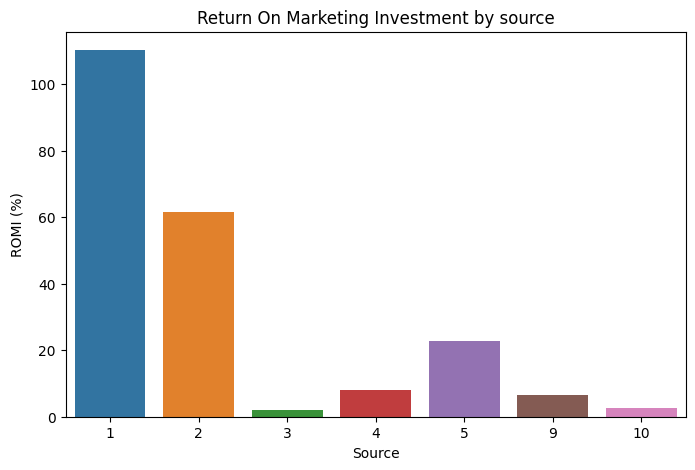

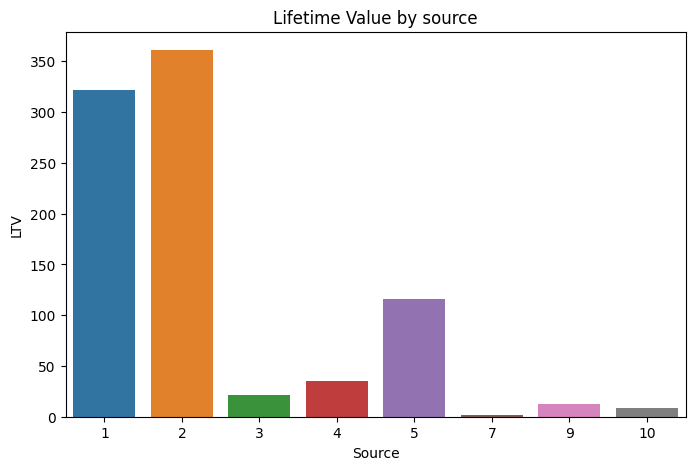

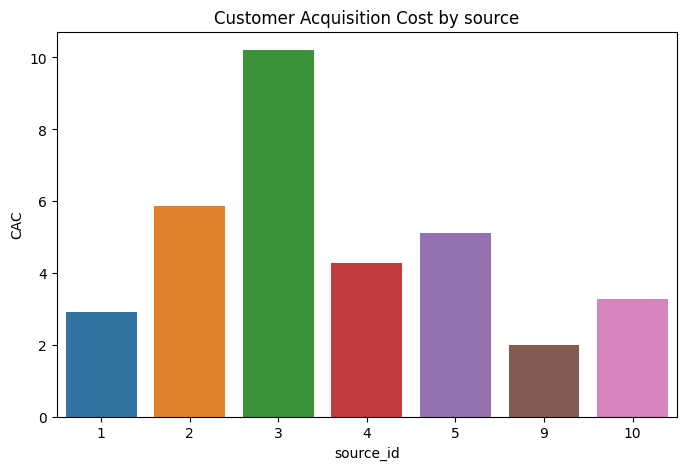

In [14]:

import matplotlib.pyplot as plt
import seaborn as sns

# ROMI by source

plt.figure(figsize=(8,5))
sns.barplot(data=romi_df, x="source_id", y="ROMI")
plt.title("Return On Marketing Investment by source")
plt.xlabel("Source")
plt.ylabel("ROMI (%)")
plt.show()


# LTV by source

ltv_by_source = ltv_by_source.reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=ltv_by_source, x="source_id", y="LTV")
plt.title("Lifetime Value by source")
plt.xlabel("Source")
plt.ylabel("LTV")
plt.show()


# CAC by source

plt.figure(figsize=(8,5))
sns.barplot(data=cac_df, x="source_id",y="CAC")
plt.title("Customer Acquisition Cost by source")
plt.xlabel("source_id")
plt.ylabel("CAC")
plt.show()

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br />

Buena manera de mostrar los datos de cada una de las fuentas, estas graficas son especialmente utiles para saber cuales de estas fuentes han sido de ayuda para la adquisicion de clientes y de esta manera determinar con cuales se quiere seguir trabajando y con cuales no
</div>


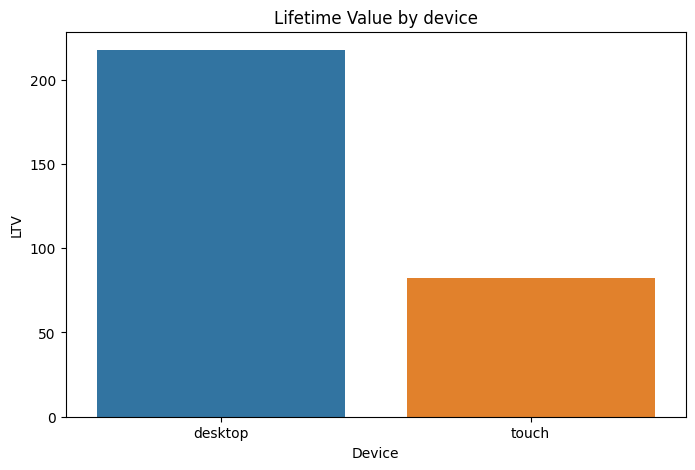

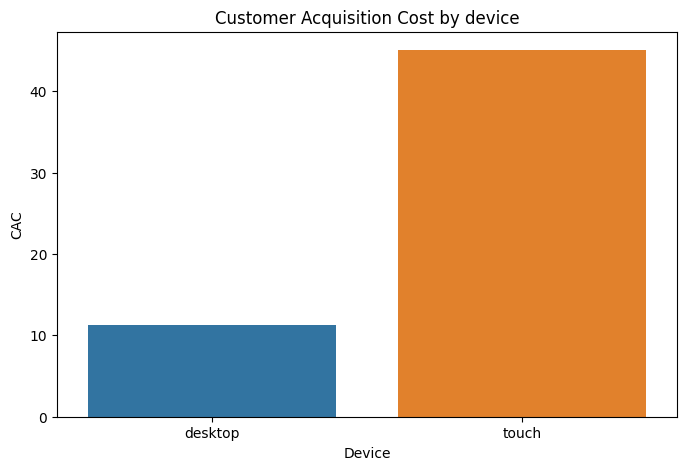

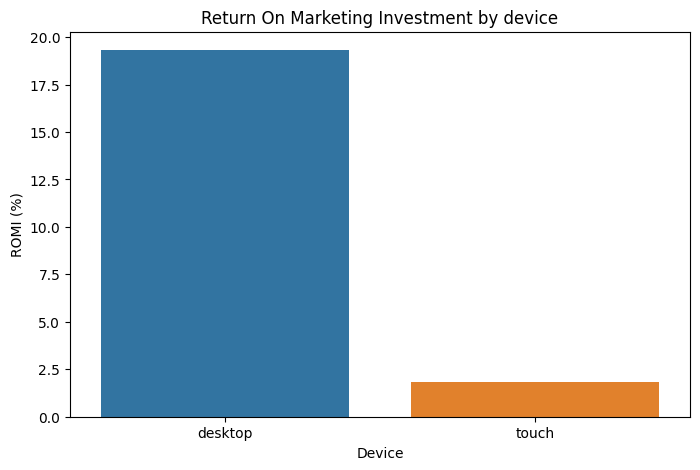

In [17]:
# LTV, CAC & ROMI BY DEVICE

# 1. Merge tables to get devices
visits_unique = visits.drop_duplicates(subset='uid')
orders_with_device = pd.merge(orders_with_source, visits_unique[["uid", "device"]], on="uid", how="inner")

# 2. Estimate LTV by device
ltv_by_device = orders_with_device.groupby("device").agg(
    total_revenue=("revenue","sum"),
    buyers=("uid", "nunique")
)
ltv_by_device["LTV"] = ltv_by_device["total_revenue"] / ltv_by_device["buyers"]
# 3. Estimate CAC by device

device_buyers = orders_with_device.groupby("device")["uid"].nunique()
device_cac = total_cost / device_buyers
ltv_by_device['CAC'] = device_cac
ltv_by_device['ROMI'] = (ltv_by_device['LTV'] / ltv_by_device['CAC']).round(2)
ltv_by_device = ltv_by_device.reset_index()

# LTV by device


plt.figure(figsize=(8,5))
sns.barplot(data=ltv_by_device, x="device", y="LTV")
plt.title("Lifetime Value by device")
plt.xlabel("Device")
plt.ylabel("LTV")
plt.show()


# CAC by device

plt.figure(figsize=(8,5))
sns.barplot(data=ltv_by_device, x="device",y="CAC")
plt.title("Customer Acquisition Cost by device")
plt.xlabel("Device")
plt.ylabel("CAC")
plt.show()


# ROMI by device

plt.figure(figsize=(8,5))
sns.barplot(data=ltv_by_device, x="device", y="ROMI")
plt.title("Return On Marketing Investment by device")
plt.xlabel("Device")
plt.ylabel("ROMI (%)")
plt.show()

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br />

Con estas graficas podemos visualizar cuales dispositivos han sido más útiles para la adquisición de clientes, con este analisis podemos decidir cuales se deben mantener y cuales eliminar
</div>




<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br />

Cuidado!

Debemos ser cuidadosos a la hora de unir dataframes, ya que estos podrían generar algun problema de memoria, es por eso que cuando hagamos la union de dos dataframes nos aseguremos de que no se genere un conjunto de datos enorme, una manera de asegurarnos de esto es eliminando los duplicados, en este caso te he ayudado a agreagr la línea que elimina los duplicados en visits
```
visits_unique = visits.drop_duplicates(subset='uid')
```
</div>


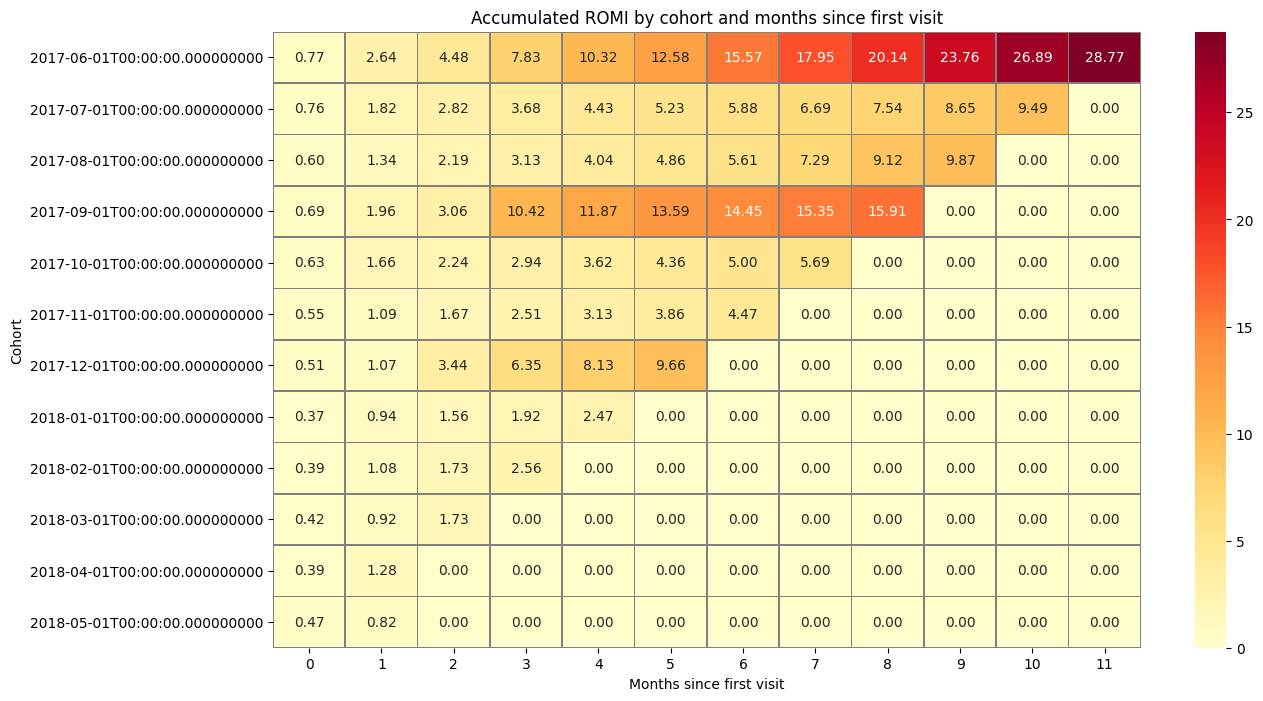

In [18]:
# Ensure datetime format for dates
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])  # Order date
cohorts['cohort_month'] = pd.to_datetime(cohorts['cohort_month'])  # Order month
cohorts['first_visit'] = pd.to_datetime(cohorts['first_visit'])    # First visit
costs['month'] = costs['month'].dt.to_timestamp()  

# Merge orders with cohorts to get info by user

orders_with_cohort = pd.merge(
    orders,
    cohorts[['uid', 'cohort_month', 'first_visit']],
    on='uid',
    how='inner'
)

# Extract month of every order 
orders_with_cohort['order_month'] = orders_with_cohort['buy_ts'].dt.to_period('M').dt.to_timestamp()

# Estimate how many months have passed since first visit until every order 
orders_with_cohort['months_after_first_visit'] = (
    orders_with_cohort['order_month'].dt.to_period('M').astype(int) -
    orders_with_cohort['first_visit'].dt.to_period('M').astype(int)
)

# Group by cohort and month since first visit to get total revenue and unique buyers 

cohort_revenue = orders_with_cohort.groupby(
    ['cohort_month', 'months_after_first_visit']
).agg(
    revenue=('revenue', 'sum'),
    buyers=('uid', 'nunique')
).reset_index()

# monthly LTV
cohort_revenue['ltv'] = cohort_revenue['revenue'] / cohort_revenue['buyers']

# LTV pivot

ltv_cum = cohort_revenue.pivot(
    index='cohort_month',
    columns='months_after_first_visit',
    values='ltv'
).cumsum(axis=1).fillna(0)

# CAC by cohort
# 1. Count users by cohort
buyers_per_cohort = orders_with_cohort.groupby('cohort_month')['uid'].nunique().reset_index(name='buyers')

# 2. Sum marketing cost by month
monthly_costs = costs.groupby('month')['costs'].sum().reset_index()

# 3.Merge both tables to get cost by cohort 

cac_by_cohort = pd.merge(
    buyers_per_cohort,
    monthly_costs,
    left_on='cohort_month',
    right_on='month',
    how='left'
)

# 4. CAC by cohort user
cac_by_cohort['CAC'] = cac_by_cohort['costs'] / cac_by_cohort['buyers']
cac_by_cohort = cac_by_cohort[['cohort_month', 'CAC']]  # select columns needed

#  ROMI
 
# Calculate cumulative ROMI by dividing the cumulative LTV for each cohort by its corresponding CAC.
# axis=0 divides row by row  (each row in ltv_cum is divided by the CAC of that cohort)

romi_cum = ltv_cum.div(cac_by_cohort.set_index('cohort_month')['CAC'], axis=0) 


#  Heatmap 
plt.figure(figsize=(14, 8))
sns.heatmap(
    romi_cum,
    annot=True,           # show values in cells
    fmt=".2f",            # 2 decimals
    cmap="YlOrRd",        # color
    linewidths=0.5,
    linecolor='gray'
)
plt.title("Accumulated ROMI by cohort and months since first visit")
plt.xlabel("Months since first visit")
plt.ylabel("Cohort")
plt.show()

## Step 3. Write a conclusion: How much and where would you recommend marketing exoerts to invest. Which sources/platforms would you recommend? Justify your answer: which metrics did you focus on? Why? What conclusions could you draw based on these?

Based on the previous analysis, we could identify the following:
-	Showz has 908 weekly, 5716 monthly and 23,228 monthly visitors on average. 
-	Daily, there are 987 sessions which are on average 11 minutes 
-	On average, users come back again 27 days after their first visit
-	On average, there are 3,878 placed monthly and the average order value is 5 USD
-	Older cohorts have a larger LTV, this makes sense since older cohorts have had more time to place orders.
For the marketing analysis, following metrics were estimated:
-	The total marketing cost equals 329,132 USD. 
-	By source, source 3 concentrates the highest spend on marketing with 141,321 USD, followed by source 4 with 61,073 USD. The spend on marketing for sources 9 & 10 is the smallest with less than 6,000 USD each.
-	During 2017 Q4 & 2018 Q1 (oct-dec & jan-mar) the marketing expenses reach the highest during the year. 
-	The source with the highest Customer Acquisition Cost is source 3 with 10.21 USD per customer followed by source 2 with 5.86 USD per customer. Source 9 has the lowest CAC with 1.98 USD per customer. 
-	By source, source 1 has the highest ROMI of 110.26%, meaning that for every 1 USD invested on marketing, 110.26 are earned. For source 2, 61.63 USD are earned and for source 3 22.81 are earned. Sources 3 and 10 are the least profitable (2.10 and 2.51 each).
-	We can see that desktops have a larger Lifetime Value than touch devices and the Customer Acquisition Cost is 3X less. Therefore, it makes sense for the ROMI for desktops to be larger than for touch devices.
-	Finally, we can see that cumulative ROMI increases for older cohorts through time. Younger cohorts have a lower ROMI but this makes sense since older cohorts have had longer time to buy.

Based on these findings, we can make Showz following recommendations:

1.	Focus on desktop ads as these attract more customers. Otherwise, develop new strategies to gain more customers through touch devices. 
2.	Ad sources 1,2 and 5 are the most profitable and the Customer Acquisition Cost is half the CAC as for source 3. 
3.	Ad source 3 should be shut down since it has the lowest lifetime value LTV and ROMI and highest CAC. This means that the marketing spend on this source is not having the expected returns and is costing a lot.


## Comentario general del revisor
<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br />

Has realizado un gran trabajo, puedo ver que has aplicado todos los conocimientos adquiridos hasta el momento, las observaciones que haces me parecen bastante profesionales, el orden en el que muestras los elementos me parece acertado, y me gusta que personalizas los distintos elementos del documento, las graficas usas colores que no son los por default, lo cual lo hace más interesante.

Continúa con el buen trabajo y mucho éxito en el siguiente Sprint!
</div>




<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br />

Recomendaría profundizar en las observaciones que se hacen a lo largo del proyecto, explicar las graficas o tablas es un gran complemento para las personas que estan tratando de entender que es lo que se muestra.

También recomendaría aprender algo de `markdown` para que cualquier escrito que hagas tenga mayor personalización y por lo tanto sea más fácil e interesante de leer
</div>
